# Loading the model from the provided checkpoint StructuredAutoreg5

In [6]:
# This file will implement the main training loop for a model
# Model 1
from time import time
import sys
import os
import argparse
# os.chdir('..')
print(os.getcwd())
#sys.path.append('../..')

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2 as Data

from disentanglement_transformer.models import DisentanglementTransformerVAE as Model
from disentanglement_transformer.h_params import DefaultTransformerHParams as HParams
from disentanglement_transformer.graphs import *
from disentanglement_transformer.graphs import get_structured_auto_regressive_graph
from components.criteria import *
parser = argparse.ArgumentParser()

# Training and Optimization
parser.add_argument("--test_name", default='nlilm/StructuredAutoreg5', type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=10000, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--z_size", default=768, type=int)#################"
parser.add_argument("--n_latents", default=[16, 16, 16], type=int)#################"
parser.add_argument("--text_rep_l", default=2, type=int)
parser.add_argument("--text_rep_h", default=768, type=int)
parser.add_argument("--encoder_h", default=768, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=768, type=int)
parser.add_argument("--decoder_l", default=3, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE"], type=str)
parser.add_argument("--training_iw_samples", default=5, type=int)
parser.add_argument("--testing_iw_samples", default=20, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=2000, type=int)
parser.add_argument("--anneal_kl1", default=4000, type=int)
parser.add_argument("--grad_clip", default=100., type=float)
parser.add_argument("--kl_th", default=0/(768*3), type=float or None)
parser.add_argument("--dropout", default=0.0, type=float)
parser.add_argument("--word_dropout", default=.0, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=3, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# torch.autograd.set_detect_anomaly(True)
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo]}[flags.losses]
#  LOSSES = [IWLBo]
ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]

data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, False)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos), MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.85)},
                   is_weighted=[], graph_generator=get_structured_auto_regressive_graph,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
model = Model(data.vocab, data.tags, h_params, wvs=data.wvs)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))


E:\Experiments\GLUE_BENCH


Mean length:  8.900745464443235  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  8. 10. 13. 14. 15.] std: 2.6633922182479695 n_examples: 90011


Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6612292456585793 n_examples: 10003
Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6612292456585793 n_examples: 10003


Words:  11895 , On device:  cuda
Loss Type:  VAE


Loaded model at step 25936
Unsupervised training examples:  90112
Number of parameters:  03.77 M
Inference parameters:  02.21 M
Generation parameters:  03.08 M
Embedding parameters:  01.52 M


In [49]:
import argparse

from torch import device
import torch
from torch import optim
import numpy as np

from data_prep import NLIGenData2, OntoGenData, HuggingYelp2
from disentanglement_transformer.models import DisentanglementTransformerVAE as Model
from disentanglement_transformer.h_params import DefaultTransformerHParams as HParams
from disentanglement_transformer.graphs import *
from components.criteria import *
parser = argparse.ArgumentParser()
from torch.nn import MultiheadAttention
# Training and Optimization
k, kz, klstm = 1, 1, 2
parser.add_argument("--test_name", default='unnamed', type=str)
parser.add_argument("--data", default='nli', choices=["nli", "ontonotes", "yelp"], type=str)
parser.add_argument("--max_len", default=17, type=int)
parser.add_argument("--batch_size", default=128, type=int)
parser.add_argument("--grad_accu", default=1, type=int)
parser.add_argument("--n_epochs", default=10000, type=int)
parser.add_argument("--test_freq", default=32, type=int)
parser.add_argument("--complete_test_freq", default=160, type=int)
parser.add_argument("--generation_weight", default=1, type=float)
parser.add_argument("--device", default='cuda:0', choices=["cuda:0", "cuda:1", "cuda:2", "cpu"], type=str)
parser.add_argument("--embedding_dim", default=128, type=int)#################"
parser.add_argument("--pretrained_embeddings", default=False, type=bool)#################"
parser.add_argument("--z_size", default=192*kz, type=int)#################"
parser.add_argument("--z_emb_dim", default=192*k, type=int)#################"
parser.add_argument("--n_latents", default=[16, 16, 16], nargs='+', type=int)#################"
parser.add_argument("--text_rep_l", default=3, type=int)
parser.add_argument("--text_rep_h", default=192*k, type=int)
parser.add_argument("--encoder_h", default=192*k, type=int)#################"
parser.add_argument("--encoder_l", default=2, type=int)#################"
parser.add_argument("--decoder_h", default=192*k, type=int)
parser.add_argument("--decoder_l", default=2, type=int)#################"
parser.add_argument("--highway", default=False, type=bool)
parser.add_argument("--markovian", default=True, type=bool)
parser.add_argument('--minimal_enc', dest='minimal_enc', action='store_true')
parser.add_argument('--no-minimal_enc', dest='minimal_enc', action='store_false')
parser.set_defaults(minimal_enc=False)
parser.add_argument("--losses", default='VAE', choices=["VAE", "IWAE"], type=str)
parser.add_argument("--graph", default='Normal', choices=["Discrete", "IndepInfer", "Normal", "NormalConGen", "NormalSimplePrior",
                                                          "Normal2",  "NormalLSTM"], type=str)
parser.add_argument("--training_iw_samples", default=5, type=int)
parser.add_argument("--testing_iw_samples", default=4, type=int)
parser.add_argument("--test_prior_samples", default=10, type=int)
parser.add_argument("--anneal_kl0", default=3000, type=int)
parser.add_argument("--anneal_kl1", default=25000, type=int)
parser.add_argument("--grad_clip", default=100., type=float)
parser.add_argument("--kl_th", default=0/(768*k/2), type=float or None)
parser.add_argument("--max_elbo1", default=6.0, type=float)
parser.add_argument("--max_elbo2", default=4.0, type=float)
parser.add_argument("--max_elbo_choice", default=0, type=int)
parser.add_argument("--dropout", default=0.5, type=float)
parser.add_argument("--word_dropout", default=0.3, type=float)
parser.add_argument("--l2_reg", default=0, type=float)
parser.add_argument("--lr", default=2e-4, type=float)
parser.add_argument("--lr_reduction", default=4., type=float)
parser.add_argument("--wait_epochs", default=1, type=float)
parser.add_argument("--save_all", default=True, type=bool)

flags, _ = parser.parse_known_args()

# Manual Settings, Deactivate before pushing
if True:
    flags.batch_size = 128
    flags.grad_accu = 1
    flags.max_len = 17
    flags.graph = "IndepInfer"
    flags.test_name = "nliLM/miniIndep"
    flags.data = "nli"
    flags.n_latents = [2, 2, 2]

# torch.autograd.set_detect_anomaly(True)
GRAPH = {"Discrete": get_discrete_auto_regressive_graph,
         "IndepInfer": get_structured_auto_regressive_indep_graph,
         "Normal": get_structured_auto_regressive_graph,
         "NormalConGen": get_structured_auto_regressive_graphConGen,
         "Normal2": get_structured_auto_regressive_graph2,
         "NormalLSTM": get_lstm_graph,
         "NormalSimplePrior": get_structured_auto_regressive_simple_prior}[flags.graph]
if flags.graph == "NormalLSTM":
    flags.encoder_h = int(flags.encoder_h/k*klstm)
Data = {"nli": NLIGenData2, "ontonotes": OntoGenData, "yelp": HuggingYelp2}[flags.data]
MAX_LEN = flags.max_len
BATCH_SIZE = flags.batch_size
GRAD_ACCU = flags.grad_accu
N_EPOCHS = flags.n_epochs
TEST_FREQ = flags.test_freq
COMPLETE_TEST_FREQ = flags.complete_test_freq
DEVICE = device(flags.device)
# This prevents illegal memory access on multigpu machines (unresolved issue on torch's github)
if flags.device.startswith('cuda'):
    torch.cuda.set_device(int(flags.device[-1]))
LOSSES = {'IWAE': [IWLBo],
          'VAE': [ELBo]}[flags.losses]
#  LOSSES = [IWLBo]
ANNEAL_KL = [flags.anneal_kl0*flags.grad_accu, flags.anneal_kl1*flags.grad_accu]
LOSS_PARAMS = [1]
if flags.grad_accu > 1:
    LOSS_PARAMS = [w/flags.grad_accu for w in LOSS_PARAMS]


data = Data(MAX_LEN, BATCH_SIZE, N_EPOCHS, DEVICE, pretrained=flags.pretrained_embeddings)
h_params = HParams(len(data.vocab.itos), len(data.tags.itos), MAX_LEN, BATCH_SIZE, N_EPOCHS,
                   device=DEVICE, vocab_ignore_index=data.vocab.stoi['<pad>'], decoder_h=flags.decoder_h,
                   decoder_l=flags.decoder_l, encoder_h=flags.encoder_h, encoder_l=flags.encoder_l,
                   text_rep_h=flags.text_rep_h, text_rep_l=flags.text_rep_l,
                   test_name=flags.test_name, grad_accumulation_steps=GRAD_ACCU,
                   optimizer_kwargs={'lr': flags.lr, #'weight_decay': flags.l2_reg, 't0':100, 'lambd':0.},
                                     'weight_decay': flags.l2_reg, 'betas': (0.9, 0.85)},
                   is_weighted=[], graph_generator=GRAPH,
                   z_size=flags.z_size, embedding_dim=flags.embedding_dim, anneal_kl=ANNEAL_KL,
                   grad_clip=flags.grad_clip*flags.grad_accu, kl_th=flags.kl_th, highway=flags.highway,
                   losses=LOSSES, dropout=flags.dropout, training_iw_samples=flags.training_iw_samples,
                   testing_iw_samples=flags.testing_iw_samples, loss_params=LOSS_PARAMS, optimizer=optim.AdamW,
                   markovian=flags.markovian, word_dropout=flags.word_dropout, contiguous_lm=False,
                   test_prior_samples=flags.test_prior_samples, n_latents=flags.n_latents,
                   max_elbo=[flags.max_elbo_choice, flags.max_elbo1],  # max_elbo is paper's beta
                   z_emb_dim=flags.z_emb_dim, minimal_enc=flags.minimal_enc)
val_iterator = iter(data.val_iter)
print("Words: ", len(data.vocab.itos), ", On device: ", DEVICE.type)
print("Loss Type: ", flags.losses)
model = Model(data.vocab, data.tags, h_params, wvs=data.wvs, dataset=flags.data)
if DEVICE.type == 'cuda':
    model.cuda(DEVICE)

total_unsupervised_train_samples = len(data.train_iter)*BATCH_SIZE
total_unsupervised_val_samples = len(data.val_iter)*BATCH_SIZE
print("Unsupervised training examples: ", total_unsupervised_train_samples)
print("Unsupervised val examples: ", total_unsupervised_val_samples)
current_time = time()
#print(model)
number_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.infer_bn.parameters() if p.requires_grad)
print("Inference parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.gen_bn.parameters() if p.requires_grad)
print("Generation parameters: ", "{0:05.2f} M".format(number_parameters/1e6))
number_parameters = sum(p.numel() for p in model.word_embeddings.parameters() if p.requires_grad)
print("Embedding parameters: ", "{0:05.2f} M".format(number_parameters/1e6))

Mean length:  8.900745464443235  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  8. 10. 13. 14. 15.] std: 2.6633922182479695 n_examples: 90011
Mean length: 

 8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6612292456585793 n_examples: 10003
Mean length:  8.920423872838148  Quantiles .25, 0.5, 0.7, and 0.9 : [ 7.  9. 10. 13. 14. 15.] std: 2.6612292456585793 n_examples: 10003


Words:  11895 , On device:  cuda
Loss Type:  VAE


Loaded model at step 129536
Unsupervised training examples:  90112
Unsupervised val examples:  10112
Number of parameters:  03.92 M
Inference parameters:  02.63 M
Generation parameters:  02.82 M
Embedding parameters:  01.52 M


# Building functions to sample sentences

In [50]:
model.eval()
def decode_to_text(x_hat_params, vocab_size, vocab_index):
    # It is assumed that this function is used at test time for display purposes
    # Getting the argmax from the one hot if it's not done
    while x_hat_params.shape[-1] == vocab_size and x_hat_params.ndim > 3:
        x_hat_params = x_hat_params.mean(0)
    while x_hat_params.ndim > 2 and x_hat_params.shape[-1] != self.h_params.vocab_size:
        x_hat_params = x_hat_params[0]
    if x_hat_params.shape[-1] == vocab_size:
        x_hat_params = torch.argmax(x_hat_params, dim=-1)
    assert x_hat_params.ndim == 2, "Mis-shaped generated sequence: {}".format(x_hat_params.shape)
    
    samples = [' '.join([vocab_index.itos[w]
                         for w in sen]).split('<eos>')[0].split(' !')[0].split(' .')[0].replace('<go>', '').replace('</go>', '')
               .replace('<pad>', '_').replace('_unk', '<?>')
               for sen in x_hat_params]

    return samples


def get_sentences(mdl, n_samples, gen_len=16, sample_w=False, vary_z=True, complete=None, contains=None, max_tries=100,
                  no_unk=True):
            final_text, final_samples, final_params = [], \
                                                      {'z1':[], 'z2':[], 'z3':[]} , \
                                                      {'z2':None, 'z3':None}
            trys = 0
            while n_samples>0:
                trys += 1
                go_symbol = torch.ones([n_samples]).long() * \
                            mdl.index[mdl.generated_v].stoi['<go>']
                go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
                x_prev = go_symbol
                if complete is not None:
                    for token in complete.split(' '):
                        x_prev = torch.cat([x_prev, torch.ones([n_samples, 1]).long().to(mdl.h_params.device) * \
                            mdl.index[mdl.generated_v].stoi[token]], dim=1)
                    gen_len = gen_len - len(complete.split(' '))
                temp = 1.
                z_gen = mdl.gen_bn.name_to_v['z1']
                if vary_z:
                    z_sample = z_gen.prior_sample((n_samples,))[0]
                else:
                    z_sample = z_gen.prior_sample((1,))[0]
                    z_sample = z_sample.repeat(n_samples, 1)
                z_input = {'z1': z_sample.unsqueeze(1)}
                # Structured Z case
                z1, z2 = mdl.gen_bn.name_to_v['z2'], mdl.gen_bn.name_to_v['z3']
                if vary_z:
                    mdl.gen_bn({'z1': z_sample.unsqueeze(1),
                                 'x_prev':torch.zeros((n_samples, 1, mdl.generated_v.size)).to(mdl.h_params.device)})
                    z1_sample, z2_sample = z1.post_samples.squeeze(1), z2.post_samples.squeeze(1)
                    z1_params, z2_params = z1.post_params, z2.post_params
                else:
                    mdl.gen_bn({'z1': z_sample[0].unsqueeze(0).unsqueeze(1),
                                 'x_prev':torch.zeros((1, 1, mdl.generated_v.size)).to(mdl.h_params.device)})
                    z1_sample, z2_sample = z1.post_samples.squeeze(1).repeat(n_samples, 1), z2.post_samples.squeeze(1).repeat(n_samples, 1)
                    z1_params, z2_params = {k: v.squeeze(1).repeat(n_samples, 1) for k, v in z1.post_params.items()}, \
                                           {k: v.squeeze(1).repeat(n_samples, 1) for k, v in z2.post_params.items()}
                z_input['z2'] = z1_sample.unsqueeze(1)
                z_input['z3'] = z2_sample.unsqueeze(1)
                
                # Normal Autoregressive generation
                for i in range(gen_len):
                    mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                      for k, v in z_input.items()}})
                    if not sample_w:
                        samples_i = mdl.generated_v.post_params['logits']
                    else:
                        samples_i = mdl.generated_v.posterior(logits=mdl.generated_v.post_params['logits']/temp,
                                                               temperature=1).rsample()
                    if no_unk:
                        annul_vector = 1-F.one_hot(torch.tensor([data.vocab.stoi['<unk>']]).to(DEVICE), h_params.vocab_size)
                        samples_i *= annul_vector
                    x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                       dim=-1)
    
                text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
                if contains is None:
                    return text, {'z1':z_sample, 'z2':z1_sample, 'z3':z2_sample} , {'z2':z1_params, 'z3':z2_params}
                else:
                    for i in range(n_samples):
                        # print(any([w in text[i].split(' ') for w in contains]), ':', text[i])
                        if any([w in text[i].split(' ') for w in contains]):
                            n_samples -= 1
                            final_text.append(text[i])
                            final_samples['z1'].append(z_sample[i])
                            final_samples['z2'].append(z1_sample[i])
                            final_samples['z3'].append(z2_sample[i])
                            if final_params['z2'] is None:
                                final_params['z2'] = {k: v[i].unsqueeze(0) for k, v in z1_params.items()}
                                final_params['z3'] = {k: v[i].unsqueeze(0) for k, v in z2_params.items()}
                            else:
                                
                                final_params['z2'] = {k: torch.cat([final_params['z2'][k], v[i].unsqueeze(0)]) 
                                                      for k, v in z1_params.items()}
                                final_params['z3'] = {k: torch.cat([final_params['z3'][k], v[i].unsqueeze(0)]) 
                                                      for k, v in z2_params.items()}
                                
                if max_tries == trys:
                    raise TimeoutError('Could only find {} sentences containing "{}" in {} samples'
                                       ''.format(len(final_text), contains, n_samples*max_tries))
            
            final_samples = {k: torch.cat([v_i.unsqueeze(0)for v_i in v]) for k, v in final_samples.items()}
            return final_text, final_samples, final_params


text, samples, params = get_sentences(model, 5, 16, sample_w=False, vary_z=True, complete=None, 
                                      contains=None, max_tries=150)
print(text)

[' the man is playing', ' a man is sitting on a bench', ' a boy is playing with a ball', ' a dog is running', ' a man is playing']


# Regenerating sentences after altering specific latent variables 

In [57]:
def get_alternative_sentences(mdl, prev_latent_vals, params, var_z_ids, n_samples, gen_len, complete=None, cond=False, 
                              determin_lv=0, no_unk=True):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            if cond:
                split_var_z_ids = []
                for i in range(len(h_params.n_latents)):
                    split_var_z_ids.append([v for v in var_z_ids
                                            if sum(h_params.n_latents[:i]) <= v < sum(h_params.n_latents[:i+1])])
                var_z_ids = split_var_z_ids
            else:
                var_z_ids = [var_z_ids]
            prev_latents1 = prev_latent_vals['z1'].repeat(n_samples, 1)
            prev_latents2 = prev_latent_vals['z2'].repeat(n_samples, 1)
            prev_latents3 = prev_latent_vals['z3'].repeat(n_samples, 1)    
            for var_z_ids_i in var_z_ids:
                orig_z = prev_latents1 
                orig_z1 = prev_latents2 
                orig_z2 = prev_latents3 
                z_gen, z1, z2 = mdl.gen_bn.name_to_v['z1'], mdl.gen_bn.name_to_v['z2'], mdl.gen_bn.name_to_v['z3']
                
                mdl.gen_bn({'z1': orig_z.unsqueeze(1), 'z2':orig_z1.unsqueeze(1),
                            'z3': orig_z2.unsqueeze(1), 
                            'x_prev': torch.zeros((n_samples * n_orig_sentences, 1, mdl.generated_v.size)).to(mdl.h_params.device)})
                z_sample = z_gen.prior_sample((n_samples * n_orig_sentences,))[0]
                z1_sample, z2_sample = z1.post_samples.squeeze(1), z2.post_samples.squeeze(1)
                z1_params, z2_params = z1.post_params, z2.post_params
                for id in var_z_ids_i:
                    assert id <sum(h_params.n_latents)
                    z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                    z_index = id - sum(h_params.n_latents[:z_number])
                    start, end = int(h_params.z_size/max(h_params.n_latents)*z_index), int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                    source, destination = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
                    destination[:, start:end] = source[:, start:end]
                prev_latents1 = orig_z 
                prev_latents2 = orig_z1 
                prev_latents3 = orig_z2
                if determin_lv>0:
                    orig_z2 = z2.post_params['loc'].squeeze(1)
                    if determin_lv>1:
                        orig_z1 = z1.post_params['loc'].squeeze(1)
                
            z_input = {'z1': orig_z.unsqueeze(1), 'z2': orig_z1.unsqueeze(1), 'z3': orig_z2.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                if no_unk:
                    annul_vector = 1-F.one_hot(torch.tensor([data.vocab.stoi['<unk>']]).to(DEVICE), h_params.vocab_size)
                    samples_i *= annul_vector
            
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': z_sample.tolist(), 'z2': z1_sample.tolist(), 'z3': z2_sample} , None#{'z1': z1_params, 'z2': z2_params}



# for i in range(48):
#     alt_text, alt_samples, alt_params = get_alternative_sentences(model, {k:v[:5] for k, v in samples.items()},
#                                                                   None,# [i for i in range(36,37)],
#                                                                   [i],
#                                                                   5, 16, complete=None)
#     print(i, alt_text[2::5])
print(h_params.n_latents)
lv = [5]#6, 19, 26, 29, 34, 42]
alt_text, alt_samples, alt_params = get_alternative_sentences(model, {k:v[:5] for k, v in samples.items()},
                                                              None,# [i for i in range(36,37)],
                                                              lv,
                                                              10, 16, complete=None, cond=False, determin_lv=0)

print('>'+'||'.join([text[0], str(lv[0])]+alt_text[0::5]), '\\\hline')
print('>'+'||'.join([text[1], str(lv[0])]+alt_text[1::5]), '\\\hline')
print('>'+'||'.join([text[2], str(lv[0])]+alt_text[2::5]), '\\\hline')
print('>'+'||'.join([text[3], str(lv[0])]+alt_text[3::5]), '\\\hline')
print('>'+'||'.join([text[4], str(lv[0])]+alt_text[4::5]), '\\\hline')



[2, 2, 2]


> the man is playing||5|| the man is playing|| a man is playing|| a man is playing|| a man is playing|| a man is playing|| a man is playing|| a man is playing|| a man is playing|| a man is playing|| a man is playing in a field of a race \\hline
> a man is sitting on a bench||5|| a man is sitting|| a man is sitting on a bench|| a man is sitting on a bench|| a man is sitting on a bench|| a man is sitting on a bench|| a man is sitting on a bench|| a man is sitting on|| a man is sitting on a bench|| a man is sitting on a bench|| a man is outside \\hline
> a boy is playing with a ball||5|| a girl is playing with a white and playing|| a girl is playing with a white and white and white|| a girl is playing with a white and playing|| a girl is playing with a white and playing with a ball|| a girl is playing with a ball|| a girl is playing with a ball|| a girl is playing with a white and playing with a ball|| a boy is playing with a ball|| a girl is playing with a white and playing|| a boy is pl

# Swapping latent variable values between sentences

In [59]:
def swap_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None, no_unk=True):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            n_samples = n_orig_sentences
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device) * \
                        mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            temp = 1.
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z1 = prev_latent_vals['z2'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z2 = prev_latent_vals['z3'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample, z1_sample, z2_sample = orig_z.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z1.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z2.reshape(n_samples*n_orig_sentences, -1)
            orig_z, orig_z1, orig_z2 = orig_z.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1), orig_z1.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z2.transpose(0, 1).reshape(n_samples*n_orig_sentences, -1)
            

            for id in var_z_ids:
                z_number = sum([id> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
                z_index = id - sum(h_params.n_latents[:z_number])
                start, end = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                             int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
                source, destination = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
                destination[:, start:end] = source[:, start:end]
            
            z_input = {'z1': orig_z.unsqueeze(1), 'z2': orig_z1.unsqueeze(1), 'z3': orig_z2.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                if no_unk:
                    annul_vector = 1-F.one_hot(torch.tensor([data.vocab.stoi['<unk>']]).to(DEVICE), h_params.vocab_size)
                    samples_i *= annul_vector
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z, 'z2': orig_z1, 'z3': orig_z2} ,\
                   None#{'z1': z1_params, 'z2': z2_params}
 
lv = [1]
alt_text, alt_samples, alt_params = swap_latents(model, {k:v[:5] for k, v in samples.items()},
                                                 lv,#10, 30, 43
                                                              #list(range(20, 48)), #[],
                                                 16, complete=None)
# Each line here is a single sentence taking each of the other sentences' specified lv(s) one at a time
# location : 3, 39, 47 ... meh
print(text)
# print(alt_text[0::5])
# print(alt_text[1::5])
# print(alt_text[2::5])
# print(alt_text[3::5])
# print(alt_text[4::5])
for i in range(5):
    for j in range(5):
        if i!=j:
            change1, change2 = 'Y' if (text[i] != alt_text[j*5+i])  else 'N', 'Y' if (text[j] != alt_text[i*5+j]) else 'N'
            print('||'.join([text[i], text[j], str(lv[0]), '('+change1+change2+')', alt_text[j*5+i], alt_text[i*5+j]]))

[' the man is playing', ' a man is sitting on a bench', ' a boy is playing with a ball', ' a dog is running', ' a man is playing']
 the man is playing|| a man is sitting on a bench||1||(YY)|| a man is playing|| a girl is sitting on a bench
 the man is playing|| a boy is playing with a ball||1||(NY)|| the man is playing|| there are people sitting on a bench
 the man is playing|| a dog is running||1||(YY)|| a man is playing|| people are walking down a street
 the man is playing|| a man is playing||1||(YY)|| a man is playing|| there are people
 a man is sitting on a bench|| the man is playing||1||(YY)|| a girl is sitting on a bench|| a man is playing
 a man is sitting on a bench|| a boy is playing with a ball||1||(YY)|| a woman is sitting on a bench|| a person is playing with a ball
 a man is sitting on a bench|| a dog is running||1||(YY)|| a young boy is on a bench|| a man is walking
 a man is sitting on a bench|| a man is playing||1||(YN)|| a young man is on a bench|| a man is playing
 

# Swapping latent variables within the latent code of a single sentence (negative result)

In [69]:
def swap_internal_latents(mdl, prev_latent_vals, var_z_ids, gen_len, complete=None):
            n_orig_sentences = prev_latent_vals['z1'].shape[0]
            assert len(var_z_ids) == 2
            n_samples = 1
            go_symbol = torch.ones([n_samples * n_orig_sentences]).long() * \
                        mdl.index[mdl.generated_v].stoi['<go>']
            go_symbol = go_symbol.to(mdl.h_params.device).unsqueeze(-1)
            x_prev = go_symbol
            if complete is not None:
                for token in complete.split(' '):
                    x_prev = torch.cat([x_prev, torch.ones([n_samples * n_orig_sentences, 1]).long().to(mdl.h_params.device)
                                        * mdl.index[mdl.generated_v].stoi[token]], dim=1)
                gen_len = gen_len - len(complete.split(' '))
            orig_z = prev_latent_vals['z1'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z1 = prev_latent_vals['z2'].unsqueeze(1).repeat(1, n_samples, 1)
            orig_z2 = prev_latent_vals['z3'].unsqueeze(1).repeat(1, n_samples, 1)
            z_sample, z1_sample, z2_sample = orig_z.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z1.reshape(n_samples*n_orig_sentences, -1), \
                                             orig_z2.reshape(n_samples*n_orig_sentences, -1)
            orig_z, orig_z1, orig_z2 = orig_z.reshape(n_samples*n_orig_sentences, -1), \
                                       orig_z1.reshape(n_samples*n_orig_sentences, -1), \
                                       orig_z2.reshape(n_samples*n_orig_sentences, -1)
            
            id1 = var_z_ids[0]
            z_number = sum([id1> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
            z_index = id1 - sum(h_params.n_latents[:z_number])
            start1, end1 = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                         int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
            source1, destination1 = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
            id2 = var_z_ids[1]
            z_number = sum([id2> sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
            z_index = id2 - sum(h_params.n_latents[:z_number])
            start2, end2 = int(h_params.z_size/max(h_params.n_latents)*z_index),\
                         int(h_params.z_size/max(h_params.n_latents)*(z_index+1))
            source2, destination2 = [z_sample, z1_sample, z2_sample][z_number], [orig_z, orig_z1, orig_z2][z_number]
            destination1[:, start1:end1] = source2[:, start2:end2]
            destination2[:, start2:end2] = source1[:, start1:end1]
            
            z_input = {'z1': orig_z.unsqueeze(1), 'z2': orig_z1.unsqueeze(1), 'z3': orig_z2.unsqueeze(1)}
            
            # Normal Autoregressive generation
            for i in range(gen_len):
                mdl.gen_bn({'x_prev': x_prev, **{k: v.expand(v.shape[0], i+1, v.shape[-1])
                                                  for k, v in z_input.items()}})
                samples_i = mdl.generated_v.post_params['logits']
                
                x_prev = torch.cat([x_prev, torch.argmax(samples_i,     dim=-1)[..., -1].unsqueeze(-1)],
                                   dim=-1)
            
            text = decode_to_text(x_prev, mdl.h_params.vocab_size, mdl.index[mdl.generated_v])
            return text, {'z1': orig_z, 'z2': orig_z1, 'z3': orig_z2} ,\
                   None#{'z1': z1_params, 'z2': z2_params}
 
lv = [10, 33]
alt_text, alt_samples, alt_params = swap_internal_latents(model, {k:v[:5] for k, v in samples.items()},
                                                 lv,#10, 30, 43
                                                              #list(range(20, 48)), #[],
                                                 16, complete=None)
print(text)
print(alt_text)


[' a man is looking at a man .. ', ' a little boy is looking at a red ball .. ', ' a person is looking at a large tree .. ', ' a person is looking at a man .. ', ' a man is looking at a red dog .. ']
[' a man is looking through a lake .. ', ' a little girl is looking at a red ball .. ', ' a person is sitting on a bench .. ', ' a person is looking at a man .. ', ' a man in a red shirt is walking down a sidewalk .. ']


# Getting attention heatmaps

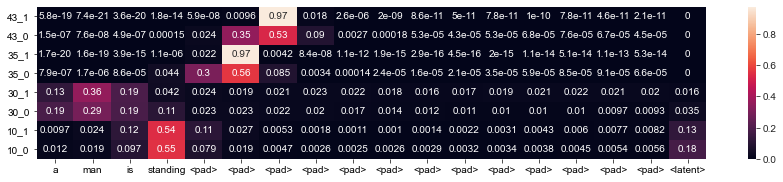

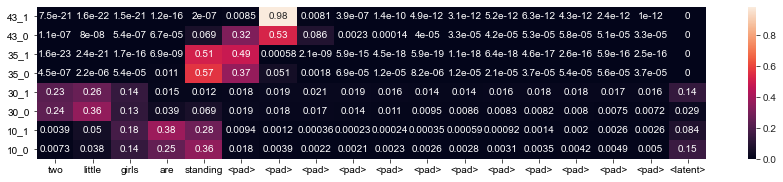

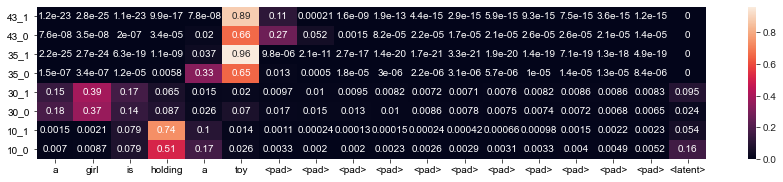

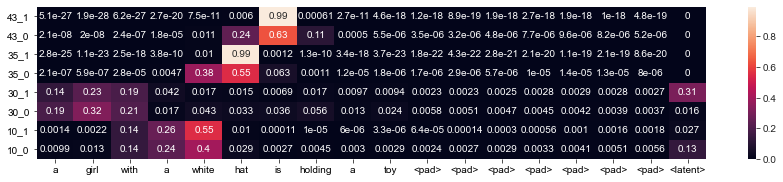

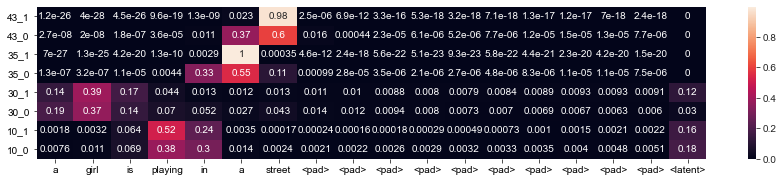

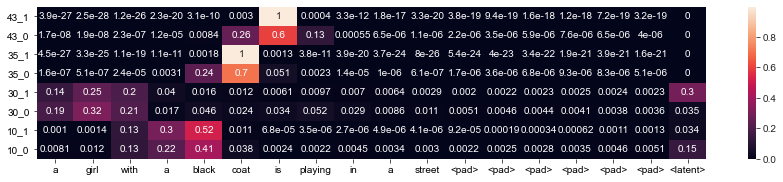

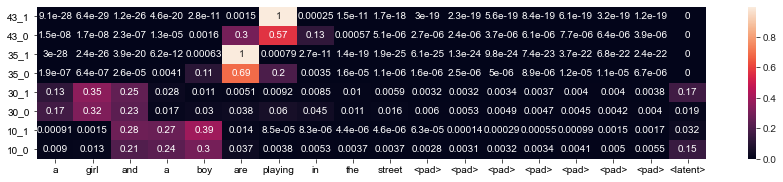

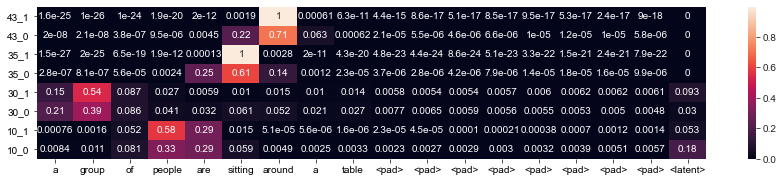

In [46]:
from components.links import CoattentiveTransformerLink, ConditionalCoattentiveTransformerLink
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
plt.figure(figsize=(20, 2))
%matplotlib inline 

def get_attention_weights(sentences, lvs):
    # Encoding sentences
    encoded = []
    lens = []
    for sen in sentences:
        sen_enc = [data.vocab.stoi[w] for w in sen.split(' ')]
        lens.append(min(len(sen_enc), MAX_LEN))
        if len(sen_enc)>=MAX_LEN:
            sen_enc = sen_enc[:MAX_LEN]
        else:
            sen_enc = sen_enc+[data.vocab.stoi['<pad>']]*(MAX_LEN-len(sen_enc))
        encoded.append(sen_enc)
    encoded = torch.Tensor(encoded).to(DEVICE).long()
    lens = torch.Tensor(lens).to(DEVICE).long()
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = True, True
    model.infer_bn({'x': encoded}, lens=lens)
    CoattentiveTransformerLink.get_att, ConditionalCoattentiveTransformerLink.get_att = False, False
    all_att_weights = []
    for i in range(len(h_params.n_latents)):
        trans_mod = model.infer_bn.approximator[model.infer_bn.name_to_v['z{}'.format(i+1)]]
        all_att_weights.append(trans_mod.att_vals)
    att_weights = []
    for lv in lvs:
        var_att_weights = []
        lv_layer = sum([lv > sum(h_params.n_latents[:i+1]) for i in range(len(h_params.n_latents))])
        rank = lv - sum(h_params.n_latents[:lv_layer])
        for layer_att_vals in all_att_weights[lv_layer]:
            soft_att_vals = layer_att_vals
            att_out = torch.cat([soft_att_vals[:, rank, :MAX_LEN], soft_att_vals[:, rank, MAX_LEN:].sum(-1).unsqueeze(-1)]
                                , -1)
            if lv_layer==2:
                att_out[..., -1] *= 0
            var_att_weights.append(att_out.cpu().detach().numpy())
        att_weights.append(var_att_weights)
    return np.transpose(np.array(att_weights), (2, 0, 1, 3))

def display_attention(sentence, att_weights, variables):
    toked = sentence.split(' ')
    toked += ['<pad>']*(MAX_LEN-len(toked))+['<latent>']
    index = []
    for i in range(len(variables)):
        for j in range(len(att_weights[i])):
            index.append(str(variables[i])+'_'+str(j))
    att_weights = att_weights.reshape(-1, MAX_LEN+1)
    data = pd.DataFrame(att_weights#[:, :len(toked)].reshape((len(att_weights), len(toked)))
                        , columns=toked, index=index)
    sns_plot = plt.figure(figsize=(15, 2.8))
    ax = plt.axes()
    g = sns.heatmap(data, annot=True, yticklabels=True, ax=ax)
    ax.set_title('')
    for tick in g.get_xticklabels():
        tick.set_color('black')
    for tick in g.get_yticklabels():
        tick.set_color('black')
    g.set_ylim([0, len(index)])
    #g.set_xticklabels(data.axes[1], rotation=55, ha="center", labelcolor='white')
    # g.get_figure()
    # plt.show()
    return sns_plot


sentences = ['a man is standing',
             'two little girls are standing',
             "a girl is holding a toy", 
             "a girl with a white hat is holding a toy", 
             "a girl is playing in a street", "a girl with a black coat is playing in a street", 
             "a girl and a boy are playing in the street",
             'a group of people are sitting around a table', ]
vars = [10, 30, 35, 43]
att_w = get_attention_weights(sentences, vars)

for sen_idx in range(len(sentences)):
    sns_plot = display_attention(sentences[sen_idx], att_w[sen_idx], vars)
    sns_plot.savefig("att_{}.png".format(sen_idx))


# Calculating and saving table of statistics

In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")


from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/openie-model.2020.03.26.tar.gz")


In [6]:

def get_sent_relations(sent):
    pred = predictor.predict(
      sentence=sent
    )
    sent_dict = []
    for el in pred['verbs']:
        sent_dict.append({})
        for v_i in el['description'].split('[')[1:]:
            in_bracket = v_i.split(']')[0]
            arg_l, arg_str = in_bracket.split(':')
            sent_dict[-1][arg_l] = arg_str
    return sent_dict

def batch_sent_relations(sents):
    target = [{'sentence': sent} for sent in sents]
    preds = predictor.predict_batch_json(target)
    sent_dicts = []
    for pred in preds:
        sent_dict = []
        for el in pred['verbs']:
            sent_dict.append({})
            for v_i in el['description'].split('[')[1:]:
                in_bracket = v_i.split(']')[0]
                arg_l, arg_str = in_bracket.split(':')
                sent_dict[-1][arg_l] = arg_str
        sent_dicts.append(sent_dict)
    return sent_dicts

print(get_sent_relations("a man is in a car .. "))
print(get_sent_relations('a blond woman throws on the floor.. '))
print(predictor.predict(sentence="The man goes to the car")['verbs'])
print(batch_sent_relations(['a blond woman throws on the floor.. ', 
                              "The man goes to the car"]))

[]
[{'ARG1': ' a blond woman', 'V': ' throws', 'ARGM-LOC': ' on the floor'}]


[{'verb': 'goes', 'description': '[ARG0: The man] [V: goes] [ARG4: to the car]', 'tags': ['B-ARG0', 'I-ARG0', 'B-V', 'B-ARG4', 'I-ARG4', 'I-ARG4']}]
[[{'ARG1': ' a blond woman', 'V': ' throws', 'ARGM-LOC': ' on the floor'}], [{'ARG0': ' The man', 'V': ' goes', 'ARG4': ' to the car'}]]


In [7]:
from time import time
def get_depth(root, toks, tree, depth=0):
    root_tree = list([tok for tok in tree[root]])
    if len(root_tree)>0:
        child_ids = [i for i, tok in enumerate(toks) if tok in root_tree]
        return 1+max([get_depth(child_id, toks, tree) for child_id in child_ids])
    else: return depth

def get_sentence_statistics2(orig, sen, orig_relations=None, relations=None):
    #print(orig, sen)
    orig, sen = orig.replace('<?>', 'UNK'), sen.replace('<?>', 'UNK')
    # Orig properties
    orig_relations = orig_relations or get_sent_relations(orig)
    orig_rel_labs = list(orig_relations[0].keys()) if len(orig_relations) else []
        
    # Alt properties
    relations = relations or get_sent_relations(sen)
    rel_labs = list(relations[0].keys()) if len(relations) else []
    # Differences 
    new_rels = np.union1d(np.setdiff1d(orig_rel_labs, rel_labs), np.setdiff1d(rel_labs, orig_rel_labs)).tolist()

    if len(new_rels) or len(rel_labs) == 0 or len(orig_rel_labs) == 0:
        rel_diff = []
    else:
        rel_diff = [k for k, v in orig_relations[0].items() if orig_relations[0][k] != relations[0][k]]
    return new_rels, rel_diff
    
def get_sentence_statistics(orig, sen, orig_relations=None, relations=None):
    #print(orig, sen)
    orig, sen = orig.replace('<?>', 'UNK'), sen.replace('<?>', 'UNK')
    # Orig properties
    orig_doc = nlp(orig)
    orig_pos = [token.pos_ for token in orig_doc]
    orig_toks = [token.text for token in orig_doc]
    orig_length = len(orig_pos)
    orig_dep_label = [token.dep_ for token in orig_doc]
    orig_dep_tree = [list(token.children) for token in orig_doc]
    orig_depth = get_depth(orig_dep_label.index('ROOT'), orig_doc, orig_dep_tree)
    orig_root_children_text = [tok.text for tok in orig_dep_tree[orig_dep_label.index('ROOT')]]
    orig_root_children_dep = [tok.dep_ for tok in orig_dep_tree[orig_dep_label.index('ROOT')]]
    n_orig_root_children = len([tok.text for tok in orig_dep_tree[orig_dep_label.index('ROOT')]])
    orig_relations = orig_relations or get_sent_relations(orig)
    orig_rel_labs = list(orig_relations[0].keys()) if len(orig_relations) else []
        
    # Alt properties
    doc = nlp(sen)
    pos = [token.pos_ for token in doc]
    toks = [token.text for token in doc]
    length = len(pos)
    dep_label = [token.dep_ for token in doc]
    dep_tree = [list(token.children) for token in doc]
    depth = get_depth(dep_label.index('ROOT'), doc, dep_tree)
    root_children_text = [tok.text for tok in dep_tree[dep_label.index('ROOT')]]
    root_children_dep = [tok.dep_ for tok in dep_tree[dep_label.index('ROOT')]]
    n_root_children = len([tok.text for tok in dep_tree[dep_label.index('ROOT')]])
    relations = relations or get_sent_relations(sen)
    rel_labs = list(relations[0].keys()) if len(relations) else []
    # Differences 
    len_diff = np.abs(length - orig_length)
    depth_diff = np.abs(depth - orig_depth)
    n_root_children_diff = np.abs(n_root_children-n_orig_root_children)
    root_children_text_diff = np.union1d(np.setdiff1d(orig_root_children_text, root_children_text),
                                        np.setdiff1d(root_children_text, orig_root_children_text)).tolist()
    root_children_dep_diff = np.union1d(np.setdiff1d(orig_root_children_dep, root_children_dep),
                                        np.setdiff1d(root_children_dep, orig_root_children_dep)).tolist()
    new_deps = np.union1d(np.setdiff1d(orig_dep_label, dep_label), np.setdiff1d(dep_label, orig_dep_label)).tolist()
    new_rels = np.union1d(np.setdiff1d(orig_rel_labs, rel_labs), np.setdiff1d(rel_labs, orig_rel_labs)).tolist()

    if len(new_rels) or len(rel_labs) == 0 or len(orig_rel_labs) == 0:
        rel_diff = []
    else:
        rel_diff = [k for k, v in orig_relations[0].items() if orig_relations[0][k] != relations[0][k]]
    if len_diff:
        word_diff = []
        diff_pos = []
        diff_dep = []
        n_word_diff = -1
    else:
        word_diff = [(orig_tok, tok) for orig_tok, tok in zip(orig_toks, toks) if orig_tok != tok]
        n_word_diff = len(word_diff)
        diff_pos = [(orig_tok.pos_, tok.pos_) for orig_tok, tok in zip(orig_doc, doc) if orig_tok.text != tok.text]
        diff_dep = [(orig_tok.dep_, tok.dep_) for orig_tok, tok in zip(orig_doc, doc) if orig_tok.text != tok.text]
    return len_diff, depth_diff, n_root_children_diff, n_word_diff, word_diff, diff_pos, diff_dep, new_deps, root_children_dep_diff, \
           root_children_text_diff, new_rels, rel_diff
    
print(text[0], alt_text[2])
# print(get_sentence_statistics('a blond woman wearing a white shirt and white shirt .. ', 'a blond woman wearing a white shirt and white shirt .. '))
print(get_sentence_statistics(text[0], alt_text[2]))
print(get_sentence_statistics('a blond woman wears a shirt .. ', 'a blond woman wears a tie .. '))

 a man is wearing a red dress ..   a man is taking a break from a hole .. 


(2, 0, 1, -1, [], [], [], ['amod', 'pobj', 'prep'], ['prep'], ['break', 'dress', 'from'], ['ARGM-DIR'], [])


(0, 0, 0, 1, [('shirt', 'tie')], [('NOUN', 'NOUN')], [('dobj', 'dobj')], [], [], ['shirt', 'tie'], [], ['ARG1'])


In [ ]:
from tqdm import tqdm
from time import time
header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
stats = []
n_samples, n_alterations, nlatents = 50, 10, h_params.n_latents
# Generating a hundred sentences
text, samples, params = get_sentences(model, n_samples=n_samples, gen_len=16, sample_w=False, vary_z=True, complete=None)
orig_rels = batch_sent_relations(text)
batch_size = 25
for i in range(int(n_samples/batch_size)):
    for j in tqdm(range(sum(nlatents)), desc="Processing sample {}".format(str(i))):
        # Altering the sentences
        alt_start = time()
        alt_text, _, _ = get_alternative_sentences(model, prev_latent_vals={k:v[i*batch_size:(i+1)*batch_size] for k, v in samples.items()},
                                                   params=None, var_z_ids=[j], n_samples=n_alterations,
                                                   gen_len=16, complete=None)
        
        alt_rels = batch_sent_relations(alt_text)
        print("alt time ", time()-alt_start)
        stat_start = time()
        # Getting alteration statistics
        for k in range(n_alterations*batch_size):
            orig_text = text[(i*batch_size)+k%batch_size]
            try:
               #  len_diff, depth_diff, n_root_children_diff, n_word_diff, word_diff, diff_pos, diff_dep, new_deps, root_children_dep_diff, \
               # root_children_text_diff, new_rels, rel_diff = get_sentence_statistics(orig_text, alt_text[k],
               #                                                                       orig_rels[(i*batch_size)+k%batch_size],
               #                                                                       alt_rels[k])
                new_rels, rel_diff = get_sentence_statistics2(orig_text, alt_text[k],
                                                                                     orig_rels[(i*batch_size)+k%batch_size],
                                                                                     alt_rels[k])
                len_diff, depth_diff, n_root_children_diff, n_word_diff, word_diff, diff_pos, diff_dep, new_deps,\
                root_children_dep_diff, root_children_text_diff = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
            except RecursionError or IndexError:
                print(orig_text, alt_text[k])
                continue
            stats.append([orig_text, alt_text[k], j, len_diff, depth_diff, n_root_children_diff, n_word_diff, 
                          word_diff, diff_pos, diff_dep, new_deps, root_children_dep_diff, 
                          root_children_text_diff, new_rels, rel_diff])
        print("stat_time", time()-stat_start)



Processing sample 0:   0%|                                                                      | 0/48 [00:00<?, ?it/s]

alt time  3.8467113971710205


Processing sample 0:   2%|█▎                                                            | 1/48 [00:04<03:15,  4.17s/it]

stat_time 0.32114243507385254


alt time  3.496647357940674


Processing sample 0:   4%|██▌                                                           | 2/48 [00:07<03:06,  4.05s/it]

stat_time 0.2812466621398926


alt time  2.808487892150879


Processing sample 0:   6%|███▉                                                          | 3/48 [00:10<02:48,  3.75s/it]

stat_time 0.22243976593017578


alt time  2.751607656478882


Processing sample 0:   8%|█████▏                                                        | 4/48 [00:13<02:34,  3.51s/it]

stat_time 0.20744609832763672


Processing sample 0:  10%|██████▍                                                       | 5/48 [00:16<02:24,  3.36s/it]

alt time  2.8314592838287354
stat_time 0.19448018074035645


alt time  2.7356836795806885
stat_time

Processing sample 0:  12%|███████▊                                                      | 6/48 [00:19<02:15,  3.23s/it]

 0.1904911994934082


Processing sample 0:  12%|███████▊                                                      | 6/48 [00:22<02:34,  3.67s/it]

KeyboardInterrupt: 

# Loading previously saved statistics dataframe or converting freshly obtained one to dataframe

In [1]:
import pandas as pd
header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
# df = pd.DataFrame(stats, columns=header)
df = pd.read_csv('result_files/Autoreg5stats2.csv')
grouped = df.groupby('alteration_id')
diff_df = grouped.mean()[['len_diff', 'depth_diff', 'n_root_children_diff']]
diff_df['len_diff'] /= diff_df['len_diff'].max()
diff_df['depth_diff'] /= diff_df['depth_diff'].max()
diff_df['n_root_children_diff'] /= diff_df['n_root_children_diff'].max()
# print(diff_df.sort_values('depth_diff', axis=0))

# Getting heatmaps for OpenIE statistics and scatter plot for Dependency parsing statistics

In [14]:
import numpy as np
orig_lens = [len(sen.strip().split(' ')) for sen in df['original']]
alt_lens = [len(sen.strip().split(' ')) for sen in df['altered']]
print(np.mean(orig_lens), np.std(orig_lens))
print(np.mean(alt_lens), np.std(alt_lens))
print(list(df['original'][0].strip().split(' ')))
print(df['original'][:10])

8.58 1.5045265035884212
8.5835 1.531851630108695
['a', 'group', 'of', 'people', 'are', 'walking', '..']
0                    a group of people are walking .. 
1                  a man is sitting down in a park .. 
2                   a man is trying to get his car .. 
3                           a man is using a phone .. 
4        a man in a blue shirt is riding a bicycle .. 
5                        a man is looking at a boy .. 
6                         a man is wearing a dress .. 
7                    a worker is sitting at a park .. 
8     a man with a pink shirt is holding a white sh...
9                             a girl is on a bench .. 
Name: original, dtype: object


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0 [0.03 0.02]
1 [0.032 0.017]
2 [0.017 0.013]
3 [0.078 0.07 ]
4 [0.037 0.021]
5 [0.043 0.012]
6 [0.024 0.02 ]
7 [0.04  0.024]
8 [0.055 0.014]
9 [0.031 0.029]
10 [0.118 0.111]
11 [0.026 0.022]
12

 [0.03  0.012]
13 [0.033 0.005]
14 [0.046 0.013]
15 [0.029 0.024]
16 [0. 0.]
17 [0.004 0.   ]
18 [0.007 0.007]
19 [0.005 0.   ]
20 [0.004 0.003]
21 [0.002 0.001]
22 [0.006 0.   ]
23

 [0.008 0.005]
24 [0.004 0.001]
25 [0.01 0.  ]
26 [0.007 0.001]
27 [0.005 0.002]
28 [0.006 0.001]
29 [0.008 0.003]
30 [0.126 0.1  ]
31 [0.005 0.001]
32 [0. 0.]
33 [0.071 0.07 ]
34 [0.006 0.001]
35 [0.128 0.043]


36 [0.01  0.006]
37 [0.054 0.035]
38 [0.019 0.018]
39 [0.048 0.036]
40 [0.01  0.008]
41 [0.002 0.   ]
42 [0.05  0.026]
43 [0.096 0.095]
44 [0.007 0.004]
45 [0.009 0.008]
46 [0.043 0.025]
47 [0.057 0.049]


disentanglement scores : 0.135 and 0.43500000000000005
Sup disentanglement scores : 0.51 and 0.178


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(0.135, 0.43500000000000005)

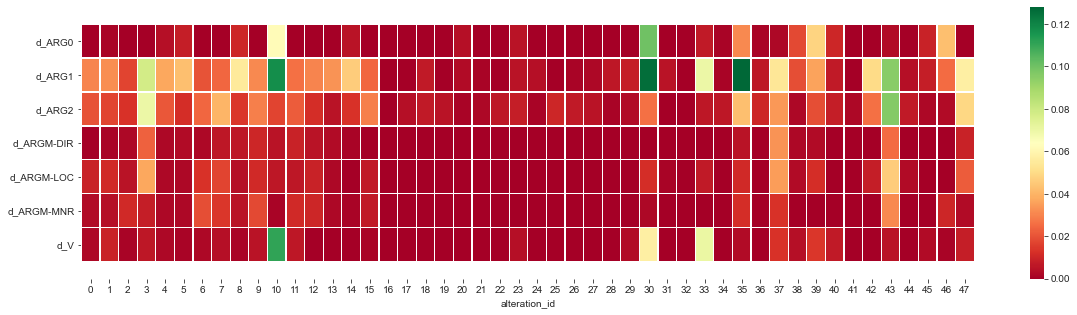

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
sns.set_style("ticks", {"xtick.major.color": 'white', "ytick.major.color": 'white'})
#dpi = 72

def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='RdYlGn', linewidths = 0.20, annot = False)#, ax=ax)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.gcf().canvas.draw()
    img_arr = np.fromstring(plt.gcf().canvas.tostring_rgb(), 
                        dtype=np.uint8,
                        sep='').reshape((360, 1440, 3))
    return snsplt.get_figure()

pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 150)
pd.options.display.max_rows = 10000

def revert_to_l1(el):
    if type(el) == list or type(el) == np.ndarray: 
        return el
    if len(el[1:-1]):
        el = el.replace('(', '').replace("'", '').replace(' ', '').replace('),', ')').replace(']', '').replace('[', '')
        output = [el_i.split(",") for el_i in el.split(')') if len(el_i)>3]
        if len(output)>1: 
            output = np.concatenate(output)
        return np.unique(output)
    else:
        return []


def disentang_metric(this_df):
    this_df['new_rels'] = this_df['new_rels'].map(revert_to_l1)
    this_df['rel_diff'] = this_df['rel_diff'].map(revert_to_l1)
    rel_types = np.unique(np.concatenate(this_df['new_rels'].array))
    for ty in rel_types:
        concerned = []
        for deps in this_df['new_rels'].array:
            concerned.append(ty in deps)
        this_df[ty] = concerned
    d_rel_types = ['d_'+ty for ty in np.unique(np.concatenate(this_df['rel_diff'].array))]
    for ty in d_rel_types:
        concerned = []
        for deps in this_df['rel_diff'].array:
            concerned.append(str(ty[2:]) in deps)
        this_df[ty] = concerned
    grouped = this_df.groupby('alteration_id')
    
    # print(grouped.mean()[rel_types])
    dis_diffs1 = 0
    for ty in d_rel_types:
        largest2 = np.array(grouped.mean().nlargest(2, ty)[ty].array)
        dis_diffs1 += largest2[0] - largest2[1]
    dis_diffs2 = 0
    for ty in rel_types:
        largest2 = np.array(grouped.mean().nlargest(2, ty)[ty].array)
        dis_diffs2 += largest2[0] - largest2[1]
    sup_dis_diffs1 = 0
    for i in range(48):
        largest2 = np.array(grouped.mean()[d_rel_types].transpose().nlargest(2, i)[i].array)
        sup_dis_diffs1 += largest2[0] - largest2[1]
        print(i, largest2)
    sup_dis_diffs2 = 0
    for i in range(48):
        largest2 = np.array(grouped.mean()[rel_types].transpose().nlargest(2, i)[i].array)
        sup_dis_diffs2 += largest2[0] - largest2[1]
    print("disentanglement scores : {} and {}".format(dis_diffs1, dis_diffs2))
    print("Sup disentanglement scores : {} and {}".format(sup_dis_diffs1, sup_dis_diffs2))
    plt.figure(figsize=(20, 5))
    show_df_hm2(grouped.mean()[d_rel_types].transpose())
    # plt.figure(figsize=(20, 2))
    # show_df_hm2(grouped.mean()[d_rel_types].transpose())
    return dis_diffs1, dis_diffs2

disentang_metric(df)

In [126]:
from torch.utils.tensorboard import SummaryWriter
swriter = SummaryWriter("tb_logs/test_dis")

In [98]:
proportion, tries, scores1, scores2 = 0.5, 50, [], []
for _ in tqdm(range(tries)):
    samples = pd.concat([df[df['alteration_id']==i].sample(frac=proportion) for i in range(48)])
    sc1, sc2 = disentang_metric(samples)
    scores1.append(sc1)
    scores2.append(sc2)
print("Score 1: {}, +-{}".format(np.mean(scores1), np.std(scores1)))
print("Score 2: {}, +-{}".format(np.mean(scores2), np.std(scores2)))

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  2%|█▋                                                                                 | 1/50 [00:00<00:40,  1.22it/s]

  4%|███▎                                                                               | 2/50 [00:01<00:42,  1.13it/s]

  6%|████▉                                                                              | 3/50 [00:02<00:41,  1.13it/s]

  8%|██████▋                                                                            | 4/50 [00:03<00:39,  1.16it/s]

 10%|████████▎                                                                          | 5/50 [00:04<00:38,  1.18it/s]

 12%|█████████▉                                                                         | 6/50 [00:05<00:36,  1.22it/s]

 14%|███████████▌                                                                       | 7/50 [00:05<00:35,  1.21it/s]

 16%|█████████████▎                                                                     | 8/50 [00:06<00:34,  1.23it/s]

 18%|██████████████▉                                                                    | 9/50 [00:07<00:33,  1.24it/s]

 20%|████████████████▍                                                                 | 10/50 [00:08<00:31,  1.25it/s]

 22%|██████████████████                                                                | 11/50 [00:09<00:30,  1.27it/s]

 24%|███████████████████▋                                                              | 12/50 [00:09<00:29,  1.30it/s]

 26%|█████████████████████▎                                                            | 13/50 [00:10<00:27,  1.33it/s]

 28%|██████████████████████▉                                                           | 14/50 [00:11<00:26,  1.35it/s]

 30%|████████████████████████▌                                                         | 15/50 [00:11<00:25,  1.38it/s]

 32%|██████████████████████████▏                                                       | 16/50 [00:12<00:24,  1.41it/s]

 34%|███████████████████████████▉                                                      | 17/50 [00:13<00:22,  1.45it/s]

 36%|█████████████████████████████▌                                                    | 18/50 [00:14<00:22,  1.40it/s]

 38%|███████████████████████████████▏                                                  | 19/50 [00:14<00:21,  1.41it/s]

 40%|████████████████████████████████▊                                                 | 20/50 [00:15<00:20,  1.44it/s]

 42%|██████████████████████████████████▍                                               | 21/50 [00:16<00:20,  1.44it/s]

 44%|████████████████████████████████████                                              | 22/50 [00:16<00:19,  1.44it/s]

 46%|█████████████████████████████████████▋                                            | 23/50 [00:17<00:18,  1.44it/s]

 48%|███████████████████████████████████████▎                                          | 24/50 [00:18<00:17,  1.44it/s]

 50%|█████████████████████████████████████████                                         | 25/50 [00:18<00:17,  1.42it/s]

 52%|██████████████████████████████████████████▋                                       | 26/50 [00:19<00:16,  1.44it/s]

 54%|████████████████████████████████████████████▎                                     | 27/50 [00:20<00:15,  1.44it/s]

 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:20<00:15,  1.44it/s]

 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:21<00:14,  1.42it/s]

 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:22<00:13,  1.43it/s]

 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:23<00:13,  1.43it/s]

 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:23<00:12,  1.47it/s]

 66%|██████████████████████████████████████████████████████                            | 33/50 [00:24<00:11,  1.46it/s]

 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:25<00:10,  1.47it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:25<00:10,  1.46it/s]

 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:26<00:09,  1.48it/s]

 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:27<00:08,  1.48it/s]

 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:27<00:08,  1.47it/s]

 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:28<00:07,  1.47it/s]

 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:29<00:06,  1.48it/s]

 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:29<00:06,  1.44it/s]

 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:30<00:05,  1.46it/s]

 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:31<00:04,  1.45it/s]

 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:31<00:04,  1.45it/s]

 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:32<00:03,  1.46it/s]

 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:33<00:02,  1.47it/s]

 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:33<00:02,  1.46it/s]

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:34<00:01,  1.46it/s]

 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:35<00:00,  1.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.46it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:35<00:00,  1.39it/s]

Score 1: 0.13728, +-0.024002533199643742
Score 2: 0.4466400000000001, +-0.06397179378444848


In [12]:
# print(np.unique(df['new_deps'].array, return_counts=True))#'root_children_diff',
from tqdm import tqdm
import numpy as np
header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
print(df['diff_dep'].array[116], )

df['diff_dep'] = df['diff_dep'].map(revert_to_l1)
df['new_deps'] = df['new_deps'].map(revert_to_l1)
df['root_children_dep_diff'] = df['root_children_dep_diff'].map(revert_to_l1)
df['new_rels'] = df['new_rels'].map(revert_to_l1)
df['rel_diff'] = df['rel_diff'].map(revert_to_l1)
print(df['diff_dep'].array[0], df['diff_dep'].array[7])

d_dep_types = ['d_'+ty for ty in np.unique(np.concatenate(df['diff_dep'].array))]
for ty in tqdm(d_dep_types):
    concerned = []
    for deps in df['diff_dep'].array:
        concerned.append(ty[2:] in deps)
    df[ty] = concerned

dep_types = np.unique(np.concatenate(df['new_deps'].array))
for ty in tqdm(dep_types):
    concerned = []
    for deps in df['new_deps'].array:
        concerned.append(ty in deps)
    df[ty] = concerned
c_dep_types = ['c_'+ty for ty in np.unique(np.concatenate(df['root_children_dep_diff'].array))]
for ty in tqdm(c_dep_types):
    concerned = []
    for deps in df['root_children_dep_diff'].array:
        concerned.append(ty[2:] in deps)
    df[ty] = concerned

rel_types = np.unique(np.concatenate(df['new_rels'].array))
for ty in tqdm(rel_types):
    concerned = []
    for deps in df['new_rels'].array:
        concerned.append(ty in deps)
    df[ty] = concerned
d_rel_types = ['d_'+ty for ty in np.unique(np.concatenate(df['rel_diff'].array))]
for ty in tqdm(d_rel_types):
    concerned = []
    for deps in df['rel_diff'].array:
        concerned.append(ty[2:] in deps)
    df[ty] = concerned



[]
[] ['pobj']


  0%|          | 0/25 [00:00<?, ?it/s]

  4%|▍         | 1/25 [00:00<00:04,  5.32it/s]

  8%|▊         | 2/25 [00:00<00:04,  5.22it/s]

 12%|█▏        | 3/25 [00:00<00:04,  5.05it/s]

 16%|█▌        | 4/25 [00:00<00:03,  5.28it/s]

 20%|██        | 5/25 [00:00<00:03,  5.27it/s]

 24%|██▍       | 6/25 [00:01<00:03,  5.46it/s]

 28%|██▊       | 7/25 [00:01<00:03,  5.78it/s]

 32%|███▏      | 8/25 [00:01<00:02,  5.93it/s]

 36%|███▌      | 9/25 [00:01<00:02,  6.07it/s]

 40%|████      | 10/25 [00:01<00:02,  6.12it/s]

 44%|████▍     | 11/25 [00:01<00:02,  6.25it/s]

 48%|████▊     | 12/25 [00:02<00:02,  6.30it/s]

 52%|█████▏    | 13/25 [00:02<00:01,  6.37it/s]

 56%|█████▌    | 14/25 [00:02<00:01,  6.37it/s]

 60%|██████    | 15/25 [00:02<00:01,  6.15it/s]

 64%|██████▍   | 16/25 [00:02<00:01,  6.14it/s]

 68%|██████▊   | 17/25 [00:02<00:01,  5.95it/s]

 72%|███████▏  | 18/25 [00:03<00:01,  5.90it/s]

 76%|███████▌  | 19/25 [00:03<00:01,  5.83it/s]

 80%|████████  | 20/25 [00:03<00:00,  5.89it/s]

 84%|████████▍ | 21/25 [00:03<00:00,  6.02it/s]

 88%|████████▊ | 22/25 [00:03<00:00,  6.17it/s]

 92%|█████████▏| 23/25 [00:03<00:00,  6.22it/s]

 96%|█████████▌| 24/25 [00:04<00:00,  6.15it/s]

100%|██████████| 25/25 [00:04<00:00,  6.05it/s]

100%|██████████| 25/25 [00:04<00:00,  5.94it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  4%|▎         | 1/27 [00:00<00:03,  6.63it/s]

  7%|▋         | 2/27 [00:00<00:03,  6.31it/s]

 11%|█         | 3/27 [00:00<00:03,  6.31it/s]

 15%|█▍        | 4/27 [00:00<00:03,  6.17it/s]

 19%|█▊        | 5/27 [00:00<00:03,  6.14it/s]

 22%|██▏       | 6/27 [00:00<00:03,  6.10it/s]

 26%|██▌       | 7/27 [00:01<00:03,  6.08it/s]

 30%|██▉       | 8/27 [00:01<00:03,  5.94it/s]

 33%|███▎      | 9/27 [00:01<00:03,  5.77it/s]

 37%|███▋      | 10/27 [00:01<00:02,  5.96it/s]

 41%|████      | 11/27 [00:01<00:02,  5.99it/s]

 44%|████▍     | 12/27 [00:01<00:02,  6.13it/s]

 48%|████▊     | 13/27 [00:02<00:02,  6.18it/s]

 52%|█████▏    | 14/27 [00:02<00:02,  6.29it/s]

 56%|█████▌    | 15/27 [00:02<00:01,  6.35it/s]

 59%|█████▉    | 16/27 [00:02<00:01,  6.36it/s]

 63%|██████▎   | 17/27 [00:02<00:01,  6.34it/s]

 67%|██████▋   | 18/27 [00:02<00:01,  6.32it/s]

 70%|███████   | 19/27 [00:03<00:01,  6.35it/s]

 74%|███████▍  | 20/27 [00:03<00:01,  5.61it/s]

 78%|███████▊  | 21/27 [00:03<00:01,  4.26it/s]

 81%|████████▏ | 22/27 [00:03<00:01,  4.62it/s]

 85%|████████▌ | 23/27 [00:04<00:00,  4.80it/s]

 89%|████████▉ | 24/27 [00:04<00:00,  5.05it/s]

 93%|█████████▎| 25/27 [00:04<00:00,  5.28it/s]

 96%|█████████▋| 26/27 [00:04<00:00,  5.42it/s]

100%|██████████| 27/27 [00:04<00:00,  5.35it/s]

100%|██████████| 27/27 [00:04<00:00,  5.68it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  5%|▍         | 1/22 [00:00<00:03,  5.82it/s]

  9%|▉         | 2/22 [00:00<00:03,  5.76it/s]

 14%|█▎        | 3/22 [00:00<00:03,  5.70it/s]

 18%|█▊        | 4/22 [00:00<00:03,  5.68it/s]

 23%|██▎       | 5/22 [00:00<00:02,  5.80it/s]

 27%|██▋       | 6/22 [00:01<00:02,  5.80it/s]

 32%|███▏      | 7/22 [00:01<00:02,  5.76it/s]

 36%|███▋      | 8/22 [00:01<00:02,  5.80it/s]

 41%|████      | 9/22 [00:01<00:02,  5.63it/s]

 45%|████▌     | 10/22 [00:01<00:02,  5.47it/s]

 50%|█████     | 11/22 [00:01<00:01,  5.57it/s]

 55%|█████▍    | 12/22 [00:02<00:01,  5.64it/s]

 59%|█████▉    | 13/22 [00:02<00:01,  5.72it/s]

 64%|██████▎   | 14/22 [00:02<00:01,  6.07it/s]

 68%|██████▊   | 15/22 [00:02<00:01,  6.24it/s]

 73%|███████▎  | 16/22 [00:02<00:00,  6.03it/s]

 77%|███████▋  | 17/22 [00:02<00:00,  6.18it/s]

 82%|████████▏ | 18/22 [00:03<00:00,  6.48it/s]

 86%|████████▋ | 19/22 [00:03<00:00,  6.70it/s]

 91%|█████████ | 20/22 [00:03<00:00,  6.69it/s]

 95%|█████████▌| 21/22 [00:03<00:00,  6.24it/s]

100%|██████████| 22/22 [00:03<00:00,  6.09it/s]

100%|██████████| 22/22 [00:03<00:00,  5.96it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  6%|▋         | 1/16 [00:00<00:02,  6.56it/s]

 12%|█▎        | 2/16 [00:00<00:02,  6.81it/s]

 19%|█▉        | 3/16 [00:00<00:01,  6.67it/s]

 25%|██▌       | 4/16 [00:00<00:01,  6.56it/s]

 31%|███▏      | 5/16 [00:00<00:01,  6.40it/s]

 38%|███▊      | 6/16 [00:00<00:01,  6.70it/s]

 44%|████▍     | 7/16 [00:01<00:01,  6.81it/s]

 50%|█████     | 8/16 [00:01<00:01,  6.58it/s]

 56%|█████▋    | 9/16 [00:01<00:01,  6.66it/s]

 62%|██████▎   | 10/16 [00:01<00:00,  6.15it/s]

 69%|██████▉   | 11/16 [00:01<00:00,  6.47it/s]

 75%|███████▌  | 12/16 [00:01<00:00,  6.72it/s]

 81%|████████▏ | 13/16 [00:01<00:00,  6.59it/s]

 88%|████████▊ | 14/16 [00:02<00:00,  6.78it/s]

 94%|█████████▍| 15/16 [00:02<00:00,  6.94it/s]

100%|██████████| 16/16 [00:02<00:00,  6.68it/s]

100%|██████████| 16/16 [00:02<00:00,  6.64it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

E:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
 14%|█▍        | 1/7 [00:00<00:01,  5.98it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.96it/s]

 43%|████▎     | 3/7 [00:00<00:00,  6.34it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  6.25it/s]

 71%|███████▏  | 5/7 [00:00<00:00,  6.45it/s]

 86%|████████▌ | 6/7 [00:00<00:00,  6.51it/s]

100%|██████████| 7/7 [00:01<00:00,  6.40it/s]

100%|██████████| 7/7 [00:01<00:00,  6.40it/s]

In [18]:


header = ['original', 'altered', 'alteration_id', 'len_diff', 'depth_diff', 'n_root_children_diff', 
          'n_word_diff', 'word_diff', 'diff_pos', 'diff_dep', 'new_deps', 'root_children_dep_diff',
           'root_children_text_diff', 'new_rels', 'rel_diff']
pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 150)
pd.options.display.max_rows = 10000


grouped = df.groupby('alteration_id')
# print(grouped.mean()[dep_types])
print('************ ANY ****************')
print('       *** Values ***')
print(grouped.mean()[dep_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[dep_types].idxmax())
hm_df1 = grouped.mean()[dep_types].transpose()
print('************ ROOT ****************')
print('       *** Values ***')
print(grouped.mean()[c_dep_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[c_dep_types].idxmax())
hm_df2 = grouped.mean()[c_dep_types].transpose()#root
print('************ ROOT ****************')
print('       *** Values ***')
print(grouped.mean()[d_dep_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[d_dep_types].idxmax())
hm_df22 = grouped.mean()[d_dep_types].transpose()#diff
print('************ relation differences ****************')
print('       *** Values ***')
print(grouped.mean()[rel_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[rel_types].idxmax())
hm_df3 = grouped.mean()[rel_types].transpose()
print('************ relation Appearances ****************')
print('       *** Values ***')
print(grouped.mean()[d_rel_types].max())
print('       ***  IDX   ***')
print(grouped.mean()[d_rel_types].idxmax())
hm_df4 = grouped.mean()[d_rel_types].transpose()

************ ANY ****************
       *** Values ***
acl          0.013
acomp        0.081
advcl        0.009
advmod       0.042
agent        0.003
amod         0.342
appos        0.003
attr         0.019
aux          0.124
auxpass      0.005
cc           0.036
compound     0.016
conj         0.036
det          0.003
dobj         0.352
expl         0.003
mark         0.003
neg          0.007
nsubj        0.012
nsubjpass    0.005
nummod       0.030
pcomp        0.001
pobj         0.314
poss         0.105
prep         0.317
prt          0.048
xcomp        0.086
dtype: float64
       ***  IDX   ***
acl          30
acomp        10
advcl        30
advmod       30
agent        10
amod         30
appos        10
attr         10
aux          30
auxpass      10
cc           30
compound      3
conj         30
det          33
dobj         10
expl         30
mark         30
neg          30
nsubj        30
nsubjpass    30
nummod       30
pcomp        37
pobj         10
poss         10
prep      

************ ROOT ****************
       *** Values ***
c_acl          0.001
c_acomp        0.081
c_advcl        0.008
c_advmod       0.043
c_agent        0.003
c_amod         0.002
c_appos        0.002
c_attr         0.018
c_aux          0.101
c_auxpass      0.005
c_cc           0.003
c_conj         0.003
c_det          0.005
c_dobj         0.324
c_expl         0.003
c_neg          0.006
c_nsubj        0.013
c_nsubjpass    0.005
c_prep         0.359
c_prt          0.046
c_punct        0.001
c_xcomp        0.026
dtype: float64
       ***  IDX   ***
c_acl          30
c_acomp        10
c_advcl        30
c_advmod       30
c_agent        10
c_amod         10
c_appos        10
c_attr         10
c_aux          10
c_auxpass      30
c_cc           47
c_conj         47
c_det          30
c_dobj         10
c_expl         30
c_neg          30
c_nsubj        30
c_nsubjpass    30
c_prep         10
c_prt          10
c_punct         3
c_xcomp        10
dtype: int64


************ ROOT ****************
       *** Values ***
d_ROOT        0.230
d_acl         0.001
d_acomp       0.007
d_advcl       0.005
d_advmod      0.010
d_agent       0.001
d_amod        0.064
d_attr        0.001
d_aux         0.055
d_auxpass     0.001
d_cc          0.003
d_compound    0.009
d_conj        0.007
d_det         0.104
d_dobj        0.090
d_expl        0.001
d_neg         0.002
d_nsubj       0.200
d_nummod      0.013
d_pcomp       0.001
d_pobj        0.253
d_poss        0.027
d_prep        0.204
d_prt         0.012
d_xcomp       0.006
dtype: float64
       ***  IDX   ***
d_ROOT        10
d_acl         10
d_acomp       30
d_advcl       30
d_advmod       1
d_agent       10
d_amod        10
d_attr        10
d_aux         30
d_auxpass     10
d_cc          30
d_compound     1
d_conj        35
d_det         10
d_dobj        35
d_expl        30
d_neg         10
d_nsubj       30
d_nummod      30
d_pcomp       37
d_pobj        43
d_poss        10
d_prep        10
d_prt         1

************ relation differences ****************
       *** Values ***
ARG0        0.397
ARG1        0.401
ARG2        0.238
ARG4        0.008
ARGM-ADV    0.011
ARGM-COM    0.004
ARGM-DIR    0.114
ARGM-EXT    0.009
ARGM-GOL    0.004
ARGM-LOC    0.259
ARGM-MNR    0.117
ARGM-NEG    0.006
ARGM-PRD    0.001
ARGM-PRP    0.001
ARGM-TMP    0.003
V           0.168
dtype: float64
       ***  IDX   ***
ARG0        10
ARG1        10
ARG2        10
ARG4        30
ARGM-ADV    37
ARGM-COM    39
ARGM-DIR    10
ARGM-EXT    10
ARGM-GOL    11
ARGM-LOC    10
ARGM-MNR    10
ARGM-NEG    30
ARGM-PRD    35
ARGM-PRP    10
ARGM-TMP    30
V           10
dtype: int64


************ relation Appearances ****************
       *** Values ***
d_ARG0        0.100
d_ARG1        0.128
d_ARG2        0.096
d_ARGM-DIR    0.033
d_ARGM-LOC    0.046
d_ARGM-MNR    0.031
d_V           0.111
dtype: float64
       ***  IDX   ***
d_ARG0        30
d_ARG1        35
d_ARG2        43
d_ARGM-DIR    37
d_ARGM-LOC    43
d_ARGM-MNR    43
d_V           10
dtype: int64


In [9]:

pd.set_option("display.max_columns", 100)
pd.set_option('display.width', 150)
pd.options.display.max_rows = 10000
for line in df[df['alteration_id'] == 43][['original', 'altered']].iterrows():    
    if line[1]['original'] != line[1]['altered']:
        print(line[1]['original'], line[1]['altered'])

 a man is sitting down in a park ..   a man is sitting down in front of a building .. 
 a man is trying to get his car ..   a man is trying to get to his baby .. 
 a man is looking at a boy ..   a man is looking at a large crowd .. 
 a worker is sitting at a park ..   a worker is sitting at a bar .. 
 a man is walking on a sidewalk ..   a man is walking on a street .. 
 a man is looking at a tree ..   a man is looking at a long day .. 
 a man is waiting for a game ..   a man is waiting for a performance .. 
 a man is in a blue jacket ..   a man is in a blue shirt .. 
 a man is looking at a boy ..   a man is looking at a <?> .. 
 a man is playing in a field ..   a man is playing in a yard .. 
 a man with a hat is laying down ..   a man with a hat is jumping .. 
 a group of people are walking ..   a group of people are walking down the grass .. 
 a man is trying to get his car ..   a man is trying to get home .. 
 a man is looking at a boy ..   a man is looking at a large crowd .. 
 a wo

<Figure size 1440x720 with 0 Axes>

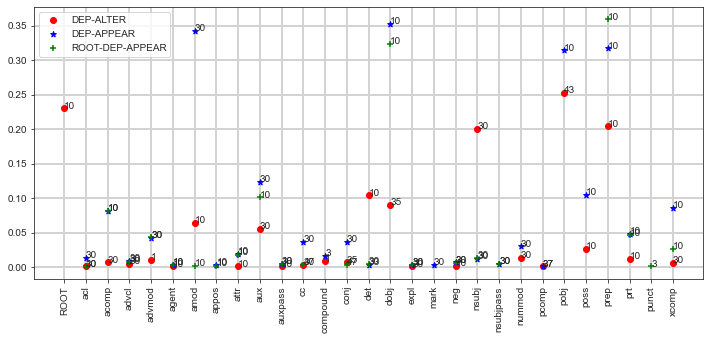

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
# hm_df1.style.background_gradient(cmap ='viridis').set_properties(**{'font-size': '20px'})
def show_df_hm1(df):
    plt.imshow(df, cmap ="RdYlBu") 
      
    # Displaying a color bar to understand 
    # which color represents which range of data 
    plt.colorbar() 
      
    # Assigning labels of x-axis  
    # according to dataframe 
    plt.xticks(range(len(df.axes[1])), df.columns) 
      
    # Assigning labels of y-axis  
    # according to dataframe 
    plt.yticks(range(len(df.axes[0])), df.index) 
      
    # Displaying the figure 
    plt.show() 
def show_df_sp(dfs):
    all_dep_labs = []
    for grp in dfs:
        # print([lab.split('_')[-1] for lab in list(grp.max().index)])
        all_dep_labs = list(np.union1d([lab.split('_')[-1] for lab in list(grp.max().index)], all_dep_labs))
    fig, ax = plt.subplots(figsize=(12,5))
    for grp, color, stat_name, mark in zip(dfs, ['red', 'blue', 'green'], ['DEP-ALTER', 'DEP-APPEAR', 'ROOT-DEP-APPEAR'],
                                     ['o', '*', '+']):

        vals = list(grp.max())
        dep_labs = [lab.split('_')[-1] for lab in list(grp.max().index)]
        dep_idx = [all_dep_labs.index(lab) for lab in dep_labs]
        lv_ids = list(grp.idxmax())
        
        ax.scatter(dep_idx, vals,c=color, label=stat_name, marker=mark)
    
        for i, txt in enumerate(lv_ids):
            ax.annotate(txt, (dep_idx[i], vals[i]))
    ax.set(xticks=range(len(all_dep_labs)), xticklabels=all_dep_labs)#, rotation='vertical') 
    for label in ax.get_xticklabels():
        label.set_rotation(90)
    ax.grid(color='lightgray', linestyle='-', linewidth=2)
    ax.legend()
          
        # Displaying the figure 
    plt.show() 
    return fig
def show_df_hm2(df):
    snsplt = sns.heatmap(df, cmap ='Reds', linewidths = 0.20, annot = False)
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return snsplt.get_figure()

sns.set_style("ticks", {"xtick.major.color": 'white', "ytick.major.color": 'white'})
plt.figure(figsize=(20, 10))
show_df_sp([grouped.mean()[d_dep_types],grouped.mean()[dep_types],
           grouped.mean()[c_dep_types]]).savefig("output.png")

#d_dep_types: diff_dep, dep_types: new_deps, c_dep_types: root_children_dep_diff
# sns_plot = show_df_hm2(hm_df1)
# sns_plot.savefig("output.png")

Index(['acl', 'acomp', 'advcl', 'advmod', 'agent', 'amod', 'appos', 'attr', 'aux', 'auxpass', 'cc', 'conj', 'det', 'dobj', 'expl', 'neg', 'nsubj',
       'nsubjpass', 'prep', 'prt', 'punct', 'xcomp'],
      dtype='object', name='dependency label')


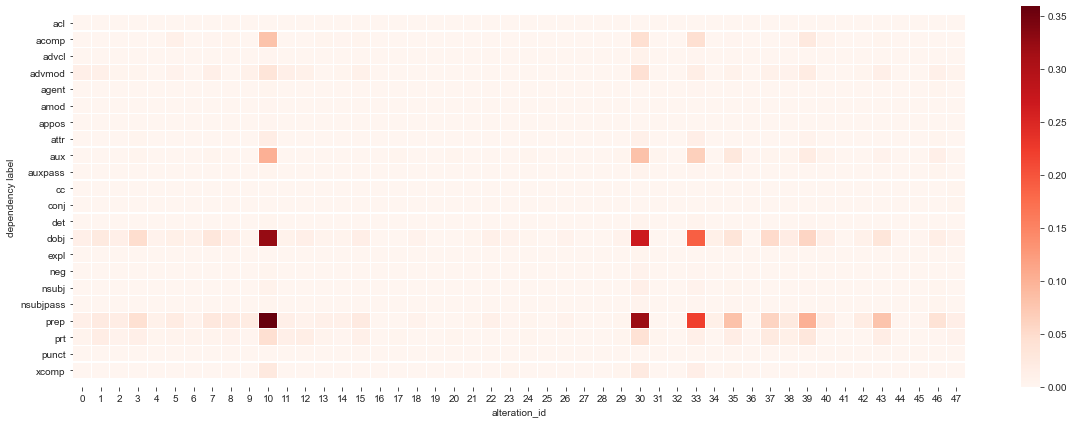

In [49]:
# hm_df1 = grouped.mean()[dep_types].transpose()
# hm_df2 = grouped.mean()[c_dep_types].transpose()#root
# hm_df22 = grouped.mean()[d_dep_types].transpose()#diff
plt.figure(figsize=(20, 7))
hm_df2['dependency label'] = [x[2:] for x in hm_df2.axes[0]]
hm_display = hm_df2.set_index('dependency label')
print(hm_display.axes[0])
sns_plot = show_df_hm2(hm_display)

sns_plot.savefig("ROOT-DEP-APPEAR-heatmap.png")

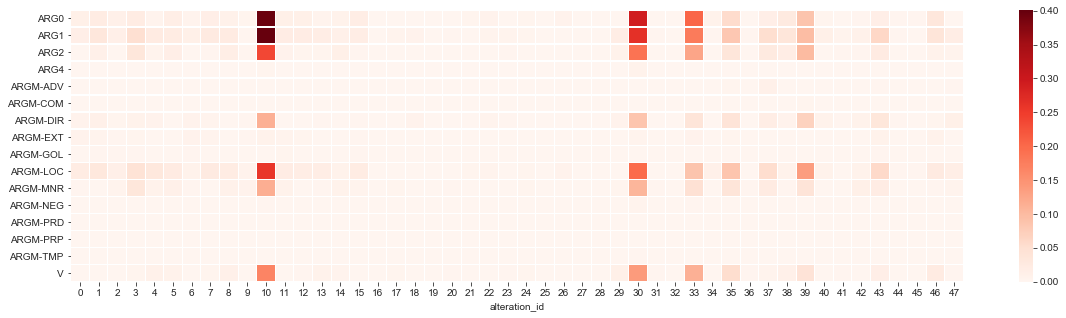

In [14]:
 
sns_plot = plt.figure(figsize=(20, 5))
show_df_hm2(hm_df3)
sns_plot.savefig("new_rels.png")

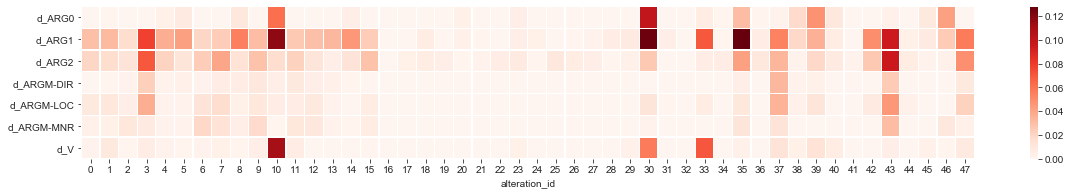

In [18]:
 
sns_plot = plt.figure(figsize=(20, 2.8))
show_df_hm2(hm_df4)
sns_plot.savefig("rel_diff.png")